## Utils


In [1]:
import pandas as pd
import glob
import os
import re
from typing import Dict, List, Tuple

parent_dir = os.path.dirname(os.getcwd())
# date = "10.28"
date_in_filename = os.path.basename(parent_dir)
date=date_in_filename.split("_")[0]

save_dir = os.path.join(parent_dir, "tex")
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

data_dir = os.path.join(parent_dir, "processed_data")


# Get session id list from data directory
session_id_list = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        session_id=file_path.split('clean_')[1].rstrip('.csv')
        session_id_list.append(session_id)



# print(date)
# print(date_in_filename)
# print(save_dir.split("tinyml_llm")[1])
# session_id_list2 = [
#      "qwen2.5-coder:32b_1974_tpusg_batch",
#     "qwen2.5-coder:32b_1974_psg_batch"
# ]

 


In [2]:

STAGE_ORDER = [
    "Data Processor",
    "Model Converter",
    "Sketch Generator",
    "PySketch Generator",
    "TPUSketch Generator",
]
STAGE_ABBR = {
    "Data Processor": "DP",
    "Model Converter": "MC",
    "Sketch Generator": "SG",
    "PySketch Generator": "PSG",
    "TPUSketch Generator": "TPUSG",
}
# Dfined for plottings
TASK_COLORS = {
    "Model Converter": "blue",
    "Data Processor": "green",
    "Sketch Generator": "purple",
    "PySketch Generator": "red",
    "TPUSketch Generator": "orange",
}


def get_sub_dir_processed_data(session_id: str) -> str:
    if session_id.startswith("da0a"):
        session_id = "phi4_" + session_id
    simple_session_id = session_id.rsplit("_", 2)[0]
    return os.path.join(data_dir, simple_session_id)


def get_model_name(tags: str) -> str:
    # Known values to exclude
    known_values = {
        "benchmark",
        "experiment",
        "data_processor",
        "model_converter",
        "sketch_generator",
        "py_sketch_generator",
        "pysketch_generator",
        "tpu_ketch_generator",
    }

    cleaned_tags = [
        tag.strip()
        for tag in tags.replace("{", "")
        .replace("}", "")
        .replace("[", "")
        .replace("]", "")
        .replace("'", "")
        .replace('"', "")
        .split(",")
    ]

    return next((tag for tag in cleaned_tags if tag and tag not in known_values), None)


def process_batch_csvs(data_dir: str) -> Tuple[pd.DataFrame, Dict[str, Dict[str, str]]]:
    """
    Process all batch CSV files in the specified directory and combine them into a single DataFrame.
    Also maintains a mapping of batch IDs to their full and short names.

    Args:
        data_dir (str): Path to the directory containing the CSV files

    Returns:
        Tuple[pd.DataFrame, Dict[str, Dict[str, str]]]:
            - Combined DataFrame
            - Dictionary mapping batch IDs to their names and short names
    """
    # Define name mappings
    processor_names = {
        "dp": {
            "full_name": "Data Processor",
            "short_name": "DP",
            "processor_type": "data_processor",
        },
        "mc": {
            "full_name": "Model Converter",
            "short_name": "MC",
            "processor_type": "model_converter",
        },
        "sg": {
            "full_name": "Sketch Generator",
            "short_name": "SG",
            "processor_type": "sketch_generator",
        },
        "psg": {
            "full_name": "PySketch Generator",
            "short_name": "PSG",
            "processor_type": "py_sketch_generator",
        },
        "tpusg": {
            "full_name": "TPUSketch Generator",
            "short_name": "TPUSG",
            "processor_type": "tpu_sketch_generator",
        },
    }

    # Initialize empty list for DataFrames and batch info
    dfs = []
    batch_info = {}

    # Pattern to match files like "clean_data_processor_2117_batch.csv"
    old_pattern = r"clean_(.+?)_(\d+)_batch\.csv"
    old_pattern2 = r"clean_(.+?)_([a-z]{2})_batch\.csv"
    pattern = (
        r"clean_(.+?)_([a-z]+)_batch\.csv"  # Process each CSV file in the directory
    )

    for filename in os.listdir(data_dir):
        print("processing ", filename)
        if filename.startswith("clean_") and filename.endswith("_batch.csv"):

            match = re.match(pattern, filename)
            if match:
                # Extract processor name and batch ID
                # eg: match.group(2) = "dp"
                processor_type = processor_names[match.group(2)]["processor_type"]
                batch_id = match.group(1) + "_" + match.group(2)  # e.g., '2117_dp'
                # Read the CSV file
                file_path = os.path.join(data_dir, filename)
                df = pd.read_csv(file_path)

                # Add metadata columns
                df["processor_type"] = processor_type
                df["batch_id"] = batch_id

                dfs.append(df)

                # Store batch information
                if any(
                    info["processor_type"] == processor_type
                    for info in processor_names.values()
                ):
                    batch_info[batch_id] = {
                        "processor_type": processor_type,
                        "full_name": processor_names[match.group(2)]["full_name"],
                        "short_name": processor_names[match.group(2)]["short_name"],
                        "model_name": get_model_name(df.iloc[0]["tags"]),
                    }
    # Combine all DataFrames
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        return combined_df, batch_info
    else:
        return pd.DataFrame(), {}


def extract_model_name(batch_info: Dict[str, Dict[str, str]]) -> str:
    model_name = next(iter(batch_info.values()))["model_name"]
    if model_name.startswith("phi4"):
        model_name = "phi4:14b"
    elif model_name.startswith("llama3.1"):
        model_name = "llama3.1:8b"
    return model_name


import ast


def parse_parameters(param_str: str) -> dict:
    """
    Parse the parameters string from the CSV into a dictionary.

    :param param_str: String representation of parameters.
    :return: Dictionary of parameters, or empty dict if not present.
    """
    if not param_str or param_str in ("{}", "null", "None"):
        return {}
    try:
        # Convert string like "{'temperature:0.1', 'top_p:0.3'}" to dict
        param_dict = {}
        # Remove braces and split by comma
        items = param_str.strip("{} ").split(",")
        for item in items:
            if "top_p" in item:
                item = item.replace("top_p", "top-p")
            if ":" in item:
                key, value = item.split(":", 1)
                param_dict[key.strip(" '\"")] = value.strip(" '\"")
         
        return param_dict
    except Exception:
        return {}


def extract_unique_parameters(df: pd.DataFrame) -> list[dict]:
    """
    Extract unique, non-empty parameter sets from the DataFrame.

    :param df: DataFrame with a 'parameters' column.
    :return: List of unique parameter dictionaries.
    """
    param_sets = set()
    for param_str in df["parameters"]:
        params = parse_parameters(param_str)
        if params:
            param_sets.add(tuple(sorted(params.items())))
    # Convert back to list of dicts
    return [dict(items) for items in param_sets]


def format_parameters_for_caption(df: pd.DataFrame) -> str:
    """
    Format parameter dictionaries for use in captions/titles.

    :param param_dicts: List of parameter dictionaries.
    :return: Formatted string.
    """
    param_dicts = extract_unique_parameters(df)

    if not param_dicts:
        return "None"
    formatted = []
    for params in param_dicts:
        formatted.append(", ".join(f"{k}={v}" for k, v in params.items()))
    return "; ".join(formatted)

### Test Utils


In [3]:
import pprint

# # Process the files
# combined_df, batch_info = process_batch_csvs(data_dir)

# # Print results
# print("Combined DataFrame shape:", combined_df.shape)
# print("\nBatch Information:")
# for batch_id, info in batch_info.items():
#     print(f"Batch {batch_id}:")
#     print(f"  Processor Type: {info['processor_type']}")
#     print(f"  Full Name: {info['full_name']}")
#     print(f"  Short Name: {info['short_name']}")


# import os

# # Get the current notebook's directory
# current_dir = os.getcwd()
# tex_dir = os.path.join(current_dir, "tex")

# # Get the parent directory
# parent_dir = os.path.dirname(os.getcwd())

# # Get just the name of the parent folder
# parent_folder_name = os.path.basename(parent_dir)

# print(f"tex directory: {tex_dir}")
# print(f"Parent directory: {parent_dir}")
# print(f"Parent folder name: {parent_folder_name}")

# Process the files
for dir in os.listdir(data_dir):
    print("\n" + "=" * 50)
    print(f"Directory: {os.path.join(data_dir, dir)}")
    print("=" * 50)

    combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
    print(f"Combined DataFrame shape: {combined_df.shape}")

    # Convert batch info to DataFrame for nice display
    batch_rows = []
    for batch_id, info in batch_info.items():
        batch_rows.append(
            {
                "Batch ID": batch_id,
                "Model": info["model_name"],
                "Processor": info["processor_type"],
                "Full Name": info["full_name"],
                "Short Name": info["short_name"],
            }
        )

    batch_df = pd.DataFrame(batch_rows)
    print("\nBatch Information:")
    parameters = format_parameters_for_caption(combined_df)

    print(f"Parameters: {parameters}")

    # print(batch_df.to_string(index=False))
    from tabulate import tabulate

    print(tabulate(batch_df, headers="keys", tablefmt="psql", showindex=False))
    print("\n")
    # print("####" * 8 + f"\nReturned combined_df:\n{combined_df.head()}")


# EXAMPLE PRINTING:

# Combined DataFrame shape: (60, 14)

# Batch Information:
# Batch 11281:
#   Processor Type: data_processor
#   Full Name: Data Processor
#   Short Name: DP
# Batch 11282:
#   Processor Type: model_converter
#   Full Name: Model Converter
#   Short Name: MC
# Batch 11283:
#   Processor Type: sketch_generator
#   Full Name: Sketch Generator
#   Short Name: SG


Directory: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/11.05/processed_data/phi4_74cc
processing  clean_phi4_74cc_sg_batch.csv
Combined DataFrame shape: (30, 17)

Batch Information:
Parameters: temperature=0.1, top-p=0.3
+--------------+-------------+------------------+------------------+--------------+
| Batch ID     | Model       | Processor        | Full Name        | Short Name   |
|--------------+-------------+------------------+------------------+--------------|
| phi4_74cc_sg | phi4:latest | sketch_generator | Sketch Generator | SG           |
+--------------+-------------+------------------+------------------+--------------+



Directory: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/11.05/processed_data/phi4_ebaa
processing  clean_phi4_ebaa_mc_batch.csv
processing  clean_phi4_ebaa_dp_batch.csv
Combined DataFrame shape: (60, 17)

Batch Information:
Parameters: temperature=0.1, top-p=0.3
+--------------+-------------+-------------

## 1. Token: overall, input, output; ave, med, max, min


In [4]:
import traceback


def calculate_token_statistics(df: pd.DataFrame, column: str) -> Dict[str, float]:
    """
    Calculate statistics for a specific token column.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Name of the column to analyze

    Returns:
        Dict[str, float]: Dictionary containing average, median, max, and min values
    """
    return {
        "average": df[column].mean(),
        "median": df[column].median(),
        "max": df[column].max(),
        "min": df[column].min(),
    }


def analyze_token_consumption(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Analyze token consumption for each processor type.

    Args:
        df (pd.DataFrame): Combined DataFrame with all batch data
        batch_info (Dict): Mapping of batch IDs to processor information

    Returns:
        Dict: Nested dictionary with statistics for each processor and token type
    """
    token_columns = {
        "overall": "total_tokens",
        "input": "prompt_tokens",
        "output": "completion_tokens",
    }

    results = {}

    # Get unique processor types
    processor_types = df["processor_type"].unique()
    print(processor_types)
    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]

        # Get statistics for each token type
        processor_stats = {}
        for token_type, column in token_columns.items():
            processor_stats[token_type] = calculate_token_statistics(
                processor_df, column
            )

        # Use the full name from batch_info for the processor
        # Get the first batch_id for this processor to look up the full name
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = processor_stats

    return results


def print_token_statistics(statistics: Dict[str, Dict[str, Dict[str, float]]]):
    """
    Print formatted token statistics.

    Args:
        statistics (Dict): Nested dictionary with token statistics
    """
    for processor, token_types in statistics.items():
        print(f"\n{processor}:")
        for token_type, stats in token_types.items():
            print(f"\n  {token_type.capitalize()} Token Consumption:")
            for stat_name, value in stats.items():
                print(f"    {stat_name.capitalize()}: {int(value)}")


def generate_combined_token_latex_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]],
    date: str,
    model_name: str,
    model_params: str,
    batch_id: str,
) -> None:
    """
    Generate a single LaTeX table combining all token statistics.

    Args:
        statistics: Nested dictionary with token statistics
        date: Date string for the file name
        tex_dir: Directory to save the LaTeX file
    """
    # Ensure tex directory exists

    # Define the order of stages and their abbreviations
    stage_order = STAGE_ORDER
    stage_abbr = STAGE_ABBR
    # LaTeX table preamble
    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{4}{c|}{Overall Token} &
          \multicolumn{4}{c|}{Input Token} &
          \multicolumn{4}{c|}{Output Token} \\ \cline{2-13}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} \\ \hline
    """

    # Print table header
    print(
        f"\nToken Statistics Table for {batch_id} ({date}, params{{{model_params}}}):"
    )
    print("-" * 80)
    print(
        "Stage      Overall Tokens (Avg/Med/Max/Min)    Input Tokens (Avg/Med/Max/Min)    Output Tokens (Avg/Med/Max/Min)"
    )
    print("-" * 80)

    # LaTeX table data filling
    latex_data = ""
    token_types = ["overall", "input", "output"]
    for stage in stage_order:
        if stage in statistics:
            abbr = stage_abbr[stage]
            row_data = [abbr]

            # Format and store values for printing
            print_row = [f"{stage_abbr[stage]:8}"]

            for token_type in token_types:
                stats = statistics[stage][token_type]
                values = [
                    str(int(stats["average"])),
                    str(int(stats["median"])),
                    str(int(stats["max"])),
                    str(int(stats["min"])),
                ]
                row_data.extend(values)

                # Add formatted values for printing
                print_row.append(f"{'/'.join(values):30}")

            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"
            # Print the formatted row
            print("".join(print_row))

    print("-" * 80)
    # LaTeX table postamble
    batch_uid = batch_id.split("_")[-2]
    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Token consumption details regarding Overall, Input, and Output in three stages. Batch ID: {batch_uid}, Model: {model_name}, Date: {date}, Parameters: {model_params}}}
        \label{{tab:token_details_{batch_uid}_{model_name}_{date}}}
        \end{{table}}
    """

    # Combine all parts
    latex_content = latex_preamble + latex_data + latex_postamble

    # Save to file
    output_file = os.path.join(
        save_dir, f"tab_token_details_{model_name}_{date_in_filename}_{batch_uid}.tex"
    )
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


try:
    # Example usage:
    for dir in os.listdir(data_dir):
        combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
        if not combined_df.empty and len(batch_info) > 0:
            model_name = extract_model_name(batch_info)
            statistics = analyze_token_consumption(combined_df, batch_info)
            model_params = format_parameters_for_caption(combined_df).replace(
                "_", r"-"
            )
            batch_id = list(batch_info)[0]
            generate_combined_token_latex_table(
                statistics, date, model_name, model_params, batch_id
            )
            # print("#" * 40 + f"\nbatch_info:\n{list(batch_info)[0]}\n" + "#" * 40)
except Exception as e:
    print(f"Error: {e}")
    print("Traceback:")
    traceback.print_exc()


# print_token_statistics(statistics)

processing  clean_phi4_74cc_sg_batch.csv
['sketch_generator']

Token Statistics Table for phi4_74cc_sg (11.05, params{temperature=0.1, top-p=0.3}):
--------------------------------------------------------------------------------
Stage      Overall Tokens (Avg/Med/Max/Min)    Input Tokens (Avg/Med/Max/Min)    Output Tokens (Avg/Med/Max/Min)
--------------------------------------------------------------------------------
SG      16311/16894/17483/7403        10779/11189/11189/5049        5531/5705/6294/2354           
--------------------------------------------------------------------------------
LaTeX table saved to /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/11.05/tex/tab_token_details_phi4:14b_11.05_74cc.tex
processing  clean_phi4_ebaa_mc_batch.csv
processing  clean_phi4_ebaa_dp_batch.csv
['model_converter' 'data_processor']

Token Statistics Table for phi4_ebaa_mc (11.05, params{temperature=0.1, top-p=0.3}):
--------------------------------------------------

## 2. Cost: overall, input, output; ave, med, max, min


In [5]:
def calculate_cost_statistics(df: pd.DataFrame, column: str) -> Dict[str, float]:
    """
    Calculate cost statistics for a specific column.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Name of the column to analyze

    Returns:
        Dict[str, float]: Dictionary containing average, median, max, and min values
    """
    return {
        "average": df[column].mean(),
        "median": df[column].median(),
        "max": df[column].max(),
        "min": df[column].min(),
    }


def analyze_cost_consumption(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Analyze cost consumption for each processor type.

    Args:
        df (pd.DataFrame): Combined DataFrame with all batch data
        batch_info (Dict): Mapping of batch IDs to processor information

    Returns:
        Dict: Nested dictionary with statistics for each processor and cost type
    """
    cost_columns = {
        "overall": "total_cost",
        "input": "prompt_cost",
        "output": "completion_cost",
    }

    results = {}
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]
        processor_stats = {}

        for cost_type, column in cost_columns.items():
            processor_stats[cost_type] = calculate_cost_statistics(processor_df, column)

        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = processor_stats

    return results


def generate_combined_cost_latex_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]],
    date: str,
    model_name: str,
    model_params: str,
    batch_id,
) -> None:
    """
    Generate a LaTeX table combining all cost statistics.

    Args:
        statistics: Nested dictionary with cost statistics
        date: Date string for the file name
        tex_dir: Directory to save the LaTeX file
    """
    #

    stage_order = STAGE_ORDER
    stage_abbr = STAGE_ABBR

    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{4}{c|}{Overall Cost (USD cents)} &
          \multicolumn{4}{c|}{Input Cost (USD cents)} &
          \multicolumn{4}{c|}{Output Cost (USD cents)} \\ \cline{2-13}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} \\ \hline
    """

    # Print table header
    print(f"\nCost Statistics Table for {batch_id} ({date}, params{{{model_params}}}):")
    print("-" * 100)
    print(
        "Stage      Overall Cost (USD¢) (Avg/Med/Max/Min)    Input Cost (USD¢) (Avg/Med/Max/Min)    Output Cost (USD¢) (Avg/Med/Max/Min)"
    )
    print("-" * 100)

    latex_data = ""
    cost_types = ["overall", "input", "output"]
    for stage in stage_order:
        if stage in statistics:
            abbr = stage_abbr[stage]
            row_data = [abbr]

            # Format and store values for printing
            print_row = [f"{stage_abbr[stage]:8}"]

            for cost_type in cost_types:
                stats = statistics[stage][cost_type]
                # Format costs to 4 decimal places
                values = [
                    f"{100 * stats['average']:.2f}",
                    f"{100 * stats['median']:.2f}",
                    f"{100 * stats['max']:.2f}",
                    f"{100 * stats['min']:.2f}",
                ]
                row_data.extend(values)

                # Add formatted values for printing
                print_row.append(f"{'/'.join(values):35}")

            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"
            # Print the formatted row
            print("".join(print_row))
    print("-" * 100)
    batch_uid = batch_id.split("_")[-2]
    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Cost details regarding Overall, Input, and Output in three stages.  Batch ID: {batch_uid}, Model: {model_name}, Date: {date}, Parameters: {model_params}}}
        \label{{tab:cost_details_{batch_uid}_{model_name}_{date}}}
        \end{{table}}
    """

    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = os.path.join(
        save_dir, f"tab_cost_details_{model_name}_{date_in_filename}_{batch_uid}.tex"
    )
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")

 
# Example usage:
print(os.listdir(data_dir))
try:
    for dir in os.listdir(data_dir):
        if "gpt" in str(dir):
            combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
            if not combined_df.empty and len(batch_info) > 0:
                model_name = extract_model_name(batch_info)
                statistics = analyze_cost_consumption(combined_df, batch_info)
                model_params = format_parameters_for_caption(combined_df).replace(
                    "_", r"-"
                )
                generate_combined_cost_latex_table(
                    statistics, date, model_name, model_params, list(batch_info)[0]
                )
        else: 
            print(f"No GPT model data found for directory: {dir}, so skipping.")
except Exception as e:
    print(f"Error: {e}")
    print("Traceback:")
    traceback.print_exc()

# # Example usage:
# combined_df, batch_info = process_batch_csvs(data_dir)
# cost_statistics = analyze_cost_consumption(combined_df, batch_info)
# generate_combined_cost_latex_table(cost_statistics, date)

['phi4_74cc', 'phi4_ebaa']
No GPT model data found for directory: phi4_74cc, so skipping.
No GPT model data found for directory: phi4_ebaa, so skipping.


## 3. Time and Token: overall, input, output; ave, max, min


In [6]:
def calculate_basic_statistics(df: pd.DataFrame, column: str) -> Dict[str, float]:
    """Calculate average, max, and min for a given column."""
    return {
        "average": df[column].mean(),
        "max": df[column].max(),
        "min": df[column].min(),
    }


def calculate_success_rate(df: pd.DataFrame) -> float:
    """Calculate success rate from status column."""
    total_count = len(df)
    success_count = len(df[df["status"] == "success"])
    return (success_count / total_count) * 100 if total_count > 0 else 0


def analyze_performance_metrics(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """Analyze execution time, token consumption, and success rate for each processor."""
    results = {}
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]

        results[full_name] = {
            "execution_time": calculate_basic_statistics(processor_df, "latency"),
            "token_consumption": calculate_basic_statistics(
                processor_df, "total_tokens"
            ),
            "success_rate": calculate_success_rate(processor_df),
        }

    return results


def generate_performance_latex_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]],
    date: str,
    model_name: str,
    model_params: str,
    batch_id,
) -> None:
    """Generate LaTeX table for performance metrics."""

    stage_order = STAGE_ORDER
    stage_abbr = STAGE_ABBR

    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{3}{c|}{Execution Time (s)} &
          \multicolumn{3}{c|}{Token Consumption} &
          \multicolumn{1}{c|}{} \\ \cline{2-7}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} &
          \multicolumn{1}{|c|}{\multirow{-2}{*}{\shortstack{Success\\Rate}}} \\ \hline
    """

    # Print table header
    print(
        f"\nPerformance Metrics Table for {batch_id} ({date}, params{{{model_params}}}):"
    )
    print("-" * 95)
    print(
        "Stage      Execution Time (s) (Avg/Max/Min)    Token Consumption (Avg/Max/Min)    Success Rate"
    )
    print("-" * 95)

    latex_data = ""
    for stage in stage_order:
        if stage in statistics:
            stats = statistics[stage]
            abbr = stage_abbr[stage]

            row_data = [
                abbr,
                f"{stats['execution_time']['average']:.2f}",
                f"{stats['execution_time']['max']:.2f}",
                f"{stats['execution_time']['min']:.2f}",
                f"{int(stats['token_consumption']['average'])}",
                f"{int(stats['token_consumption']['max'])}",
                f"{int(stats['token_consumption']['min'])}",
                f"{stats['success_rate']/100:.3f}",
            ]

            # Print using the same values prepared for LaTeX
            print(
                f"{row_data[0]:8} {row_data[1]}/{row_data[2]}/{row_data[3]:30} {row_data[4]}/{row_data[5]}/{row_data[6]:30} {row_data[7]}"
            )

            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"

    print("-" * 95)
    batch_uid = batch_id.split("_")[-2]
    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Performance metrics including execution time, token consumption, and success rate in three stages. Batch ID: {batch_uid}, Model: {model_name}, Date: {date}, Parameters: {model_params}}}
        \label{{tab:performance_metrics_{batch_uid}_{model_name}_{date}}}
        \end{{table}}
    """

    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = (
        f"{save_dir}/tab_performance_metrics_{model_name}_{date_in_filename}_{batch_uid}.tex"
    )
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


# Example usage:
# combined_df, batch_info = process_batch_csvs(data_dir)
# performance_stats = analyze_performance_metrics(combined_df, batch_info)
# generate_performance_latex_table(performance_stats, date)
print(os.listdir(data_dir))
print(os.path.join(data_dir, dir))
for dir in os.listdir(data_dir):
    combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
    if not combined_df.empty and len(batch_info) > 0:
        model_name = extract_model_name(batch_info)
        statistics = analyze_performance_metrics(combined_df, batch_info)
        model_params = format_parameters_for_caption(combined_df).replace("_", r"-")
        generate_performance_latex_table(
            statistics, date, model_name, model_params, list(batch_info)[0]
        )

['phi4_74cc', 'phi4_ebaa']
/home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/11.05/processed_data/phi4_ebaa
processing  clean_phi4_74cc_sg_batch.csv

Performance Metrics Table for phi4_74cc_sg (11.05, params{temperature=0.1, top-p=0.3}):
-----------------------------------------------------------------------------------------------
Stage      Execution Time (s) (Avg/Max/Min)    Token Consumption (Avg/Max/Min)    Success Rate
-----------------------------------------------------------------------------------------------
SG       84.96/124.12/34.91                          16311/17483/7403                           0.000
-----------------------------------------------------------------------------------------------
LaTeX table saved to /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/11.05/tex/tab_performance_metrics_phi4:14b_11.05_74cc.tex
processing  clean_phi4_ebaa_mc_batch.csv
processing  clean_phi4_ebaa_dp_batch.csv

Performance Metrics Table f

## 4. Ave Time and Token: overall/pass/fail


In [7]:
def calculate_status_metrics(df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    """Calculate metrics for overall, passed, and failed cases."""
    # Overall metrics
    overall_metrics = {
        "execution_time": df["latency"].mean(),
        "total_tokens": df["total_tokens"].mean(),
    }

    # Success metrics
    success_df = df[df["status"] == "success"]
    if len(success_df) > 0:
        success_metrics = {
            "execution_time": success_df["latency"].mean(),
            "total_tokens": success_df["total_tokens"].mean(),
        }
    else:
        # If no success cases, set metrics to 0
        success_metrics = {
            "execution_time": 0.0,
            "total_tokens": 0.0,
        }
    # success_metrics = {
    #     "execution_time": success_df["latency"].mean(),
    #     "total_tokens": success_df["total_tokens"].mean(),
    # }

    # Error metrics
    error_df = df[df["status"] == "failure"]
    if len(error_df) > 0:
        error_metrics = {
            "execution_time": error_df["latency"].mean(),
            "total_tokens": error_df["total_tokens"].mean(),
        }
    else:
        # If no error cases, set metrics to 0
        error_metrics = {
            "execution_time": 0.0,
            "total_tokens": 0.0,
        }

    # Success rate
    total_count = len(df)
    success_rate = (len(success_df) / total_count * 100) if total_count > 0 else 0

    return {
        "overall": overall_metrics,
        "success": success_metrics,
        "error": error_metrics,
        "success_rate": success_rate,
    }


def analyze_status_by_processor(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """Analyze metrics for each processor type."""
    results = {}
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = calculate_status_metrics(processor_df)

    return results


def generate_status_latex_table(
    statistics: Dict[str, Dict[str, Dict[str, float]]],
    date: str,
    model_name: str,
    model_params: str,
    batch_id,
) -> None:
    """Generate LaTeX table for status-based metrics."""

    stage_order = STAGE_ORDER
    stage_abbr = STAGE_ABBR

    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \resizebox{\textwidth}{!}{%
        \begin{tabular}{|l|r|r|r|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{} &
          \multicolumn{3}{c|}{Ave Execution Time (s)} &
          \multicolumn{3}{c|}{Ave Total Tokens} &
          \multicolumn{1}{c|}{} \\ \cline{2-7}
        \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
          \multicolumn{1}{c|}{Overall} &
          \multicolumn{1}{c|}{Pass} &
          \multicolumn{1}{c|}{Fail} &
          \multicolumn{1}{c|}{Overall} &
          \multicolumn{1}{c|}{Pass} &
          \multicolumn{1}{c|}{Fail} &
          \multicolumn{1}{|c|}{\multirow{-2}{*}{\shortstack{Success\\Rate}}} \\ \hline
    """

    # Print table header
    print(
        f"\nStatus-based Performance Metrics for {batch_id} ({date}, params{{{model_params}}}):"
    )
    print("-" * 110)
    print(
        "Stage      Execution Time (s) (All/Pass/Fail)    Token Consumption (All/Pass/Fail)    Success Rate"
    )
    print("-" * 110)

    latex_data = ""
    for stage in stage_order:
        if stage in statistics:
            stats = statistics[stage]
            abbr = stage_abbr[stage]
            row_data = [
                abbr,
                f"{stats['overall']['execution_time']:.2f}",
                f"{stats['success']['execution_time']:.2f}",
                f"{stats['error']['execution_time']:.2f}",
                f"{int(stats['overall']['total_tokens'])}",
                f"{int(stats['success']['total_tokens'])}",
                f"{int(stats['error']['total_tokens'])}",
                f"{stats['success_rate']/100:.3f}",
            ]

            # Print using the same values prepared for LaTeX
            print(
                f"{row_data[0]:8} {row_data[1]}/{row_data[2]}/{row_data[3]:35} {row_data[4]}/{row_data[5]}/{row_data[6]:35} {row_data[7]}"
            )

            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"

    print("-" * 110)
    batch_uid = batch_id.split("_")[-2]
    latex_postamble = rf"""
        \end{{tabular}}%
        }}
        \caption{{Performance metrics of passed and failed runs,including execution time, token consumption, and success rate in three stages. Batch ID: {batch_uid}, Model: {model_name}, Date: {date}, Parameters: {model_params}}}
        \label{{tab:performance_metrics_ave_{batch_uid}_{model_name}_{date}}}
        \end{{table}}
    """

    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = (
        f"{save_dir}/tab_performance_metrics_ave_{model_name}_{date_in_filename}_{batch_uid}.tex"
    )
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


# Example usage:
for dir in os.listdir(data_dir):
    combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
    if not combined_df.empty and len(batch_info) > 0:
        model_name = extract_model_name(batch_info)
        status_stats = analyze_status_by_processor(combined_df, batch_info)
        model_params = format_parameters_for_caption(combined_df).replace("_", r"-")
        generate_status_latex_table(
            status_stats, date, model_name, model_params, list(batch_info)[0]
        )

processing  clean_phi4_74cc_sg_batch.csv

Status-based Performance Metrics for phi4_74cc_sg (11.05, params{temperature=0.1, top-p=0.3}):
--------------------------------------------------------------------------------------------------------------
Stage      Execution Time (s) (All/Pass/Fail)    Token Consumption (All/Pass/Fail)    Success Rate
--------------------------------------------------------------------------------------------------------------
SG       84.96/0.00/84.96                               16311/0/16311                               0.000
--------------------------------------------------------------------------------------------------------------
LaTeX table saved to /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/11.05/tex/tab_performance_metrics_ave_phi4:14b_11.05_74cc.tex
processing  clean_phi4_ebaa_mc_batch.csv
processing  clean_phi4_ebaa_dp_batch.csv

Status-based Performance Metrics for phi4_ebaa_mc (11.05, params{temperature=0.1, top-p=0.

## 5. Time: ave, med, max, min


In [8]:
def calculate_time_statistics(df: pd.DataFrame) -> Dict[str, float]:
    """Calculate time statistics for a specific processor."""
    return {
        "average": df["latency"].mean(),
        "median": df["latency"].median(),
        "max": df["latency"].max(),
        "min": df["latency"].min(),
    }


def analyze_time_consumption(
    df: pd.DataFrame, batch_info: Dict[str, Dict[str, str]]
) -> Dict[str, Dict[str, float]]:
    """Analyze time consumption for each processor type."""
    results = {}
    processor_types = df["processor_type"].unique()

    for processor in processor_types:
        processor_df = df[df["processor_type"] == processor]
        sample_batch_id = processor_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        results[full_name] = calculate_time_statistics(processor_df)

    return results


def generate_time_latex_table(
    statistics: Dict[str, Dict[str, float]],
    date: str,
    model_name: str,
    model_params: str,
    batch_id,
) -> None:
    """Generate LaTeX table for time consumption statistics."""

    stage_order = STAGE_ORDER
    stage_abbr = STAGE_ABBR

    latex_preamble = r"""
    \begin{table}[!h]
        \centering
        \begin{tabular}{|l|r|r|r|r|}
        \hline
        \multicolumn{1}{|c|}{Stages} &
          \multicolumn{1}{c|}{Ave} &
          \multicolumn{1}{c|}{Med} &
          \multicolumn{1}{c|}{Max} &
          \multicolumn{1}{c|}{Min} \\ \hline
    """
    # Print table header
    print(
        f"\nTime Consumption Statistics for {batch_id} ({date}, params{{{model_params}}}):"
    )
    print("-" * 70)
    print("Stage      Execution Time (seconds) (Avg/Med/Max/Min)")
    print("-" * 70)

    latex_data = ""
    for stage in stage_order:
        if stage in statistics:
            stats = statistics[stage]
            abbr = stage_abbr[stage]
            row_data = [
                abbr,
                f"{stats['average']:.2f}",
                f"{stats['median']:.2f}",
                f"{stats['max']:.2f}",
                f"{stats['min']:.2f}",
            ]

            # Format and print human-readable row
            print_row = [
                f"{stage_abbr[stage]:8}",
                f"{row_data[1]}/{row_data[2]}/{row_data[3]}/{row_data[4]}",
            ]
            print("".join(print_row))

            latex_data += " & ".join(row_data) + r" \\ \hline" + "\n"

    print("-" * 70)
    batch_uid = batch_id.split("_")[-2]
    latex_postamble = rf"""
        \end{{tabular}}
        \caption{{Time consumption (seconds) in three stages. Batch ID: {batch_uid}, Model: {model_name}, Date: {date}, Parameters: {model_params}}}
        \label{{tab:time_{batch_uid}_{model_name}_{date}}}
        \end{{table}}
    """

    latex_content = latex_preamble + latex_data + latex_postamble

    output_file = f"{save_dir}/tab_time_{model_name}_{date_in_filename}_{batch_uid}.tex"
    with open(output_file, "w") as tex_file:
        tex_file.write(latex_content)
    print(f"LaTeX table saved to {output_file}")


# Example usage:
for dir in os.listdir(data_dir):
    combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
    if not combined_df.empty and len(batch_info) > 0:
        model_name = extract_model_name(batch_info)
        time_stats = analyze_time_consumption(combined_df, batch_info)
        model_params = format_parameters_for_caption(combined_df).replace("_", r"-")
        generate_time_latex_table(
            time_stats, date, model_name, model_params, list(batch_info)[0]
        )

processing  clean_phi4_74cc_sg_batch.csv

Time Consumption Statistics for phi4_74cc_sg (11.05, params{temperature=0.1, top-p=0.3}):
----------------------------------------------------------------------
Stage      Execution Time (seconds) (Avg/Med/Max/Min)
----------------------------------------------------------------------
SG      84.96/86.04/124.12/34.91
----------------------------------------------------------------------
LaTeX table saved to /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/11.05/tex/tab_time_phi4:14b_11.05_74cc.tex
processing  clean_phi4_ebaa_mc_batch.csv
processing  clean_phi4_ebaa_dp_batch.csv

Time Consumption Statistics for phi4_ebaa_mc (11.05, params{temperature=0.1, top-p=0.3}):
----------------------------------------------------------------------
Stage      Execution Time (seconds) (Avg/Med/Max/Min)
----------------------------------------------------------------------
DP      85.01/87.11/136.81/58.12
MC      11.80/6.25/36.79/5.86
---

## 6. Bar chart: time, token; overall, passed, failed;


processing  clean_phi4_74cc_sg_batch.csv
batch_info:  {'phi4_74cc_sg': {'processor_type': 'sketch_generator', 'full_name': 'Sketch Generator', 'short_name': 'SG', 'model_name': 'phi4:latest'}}


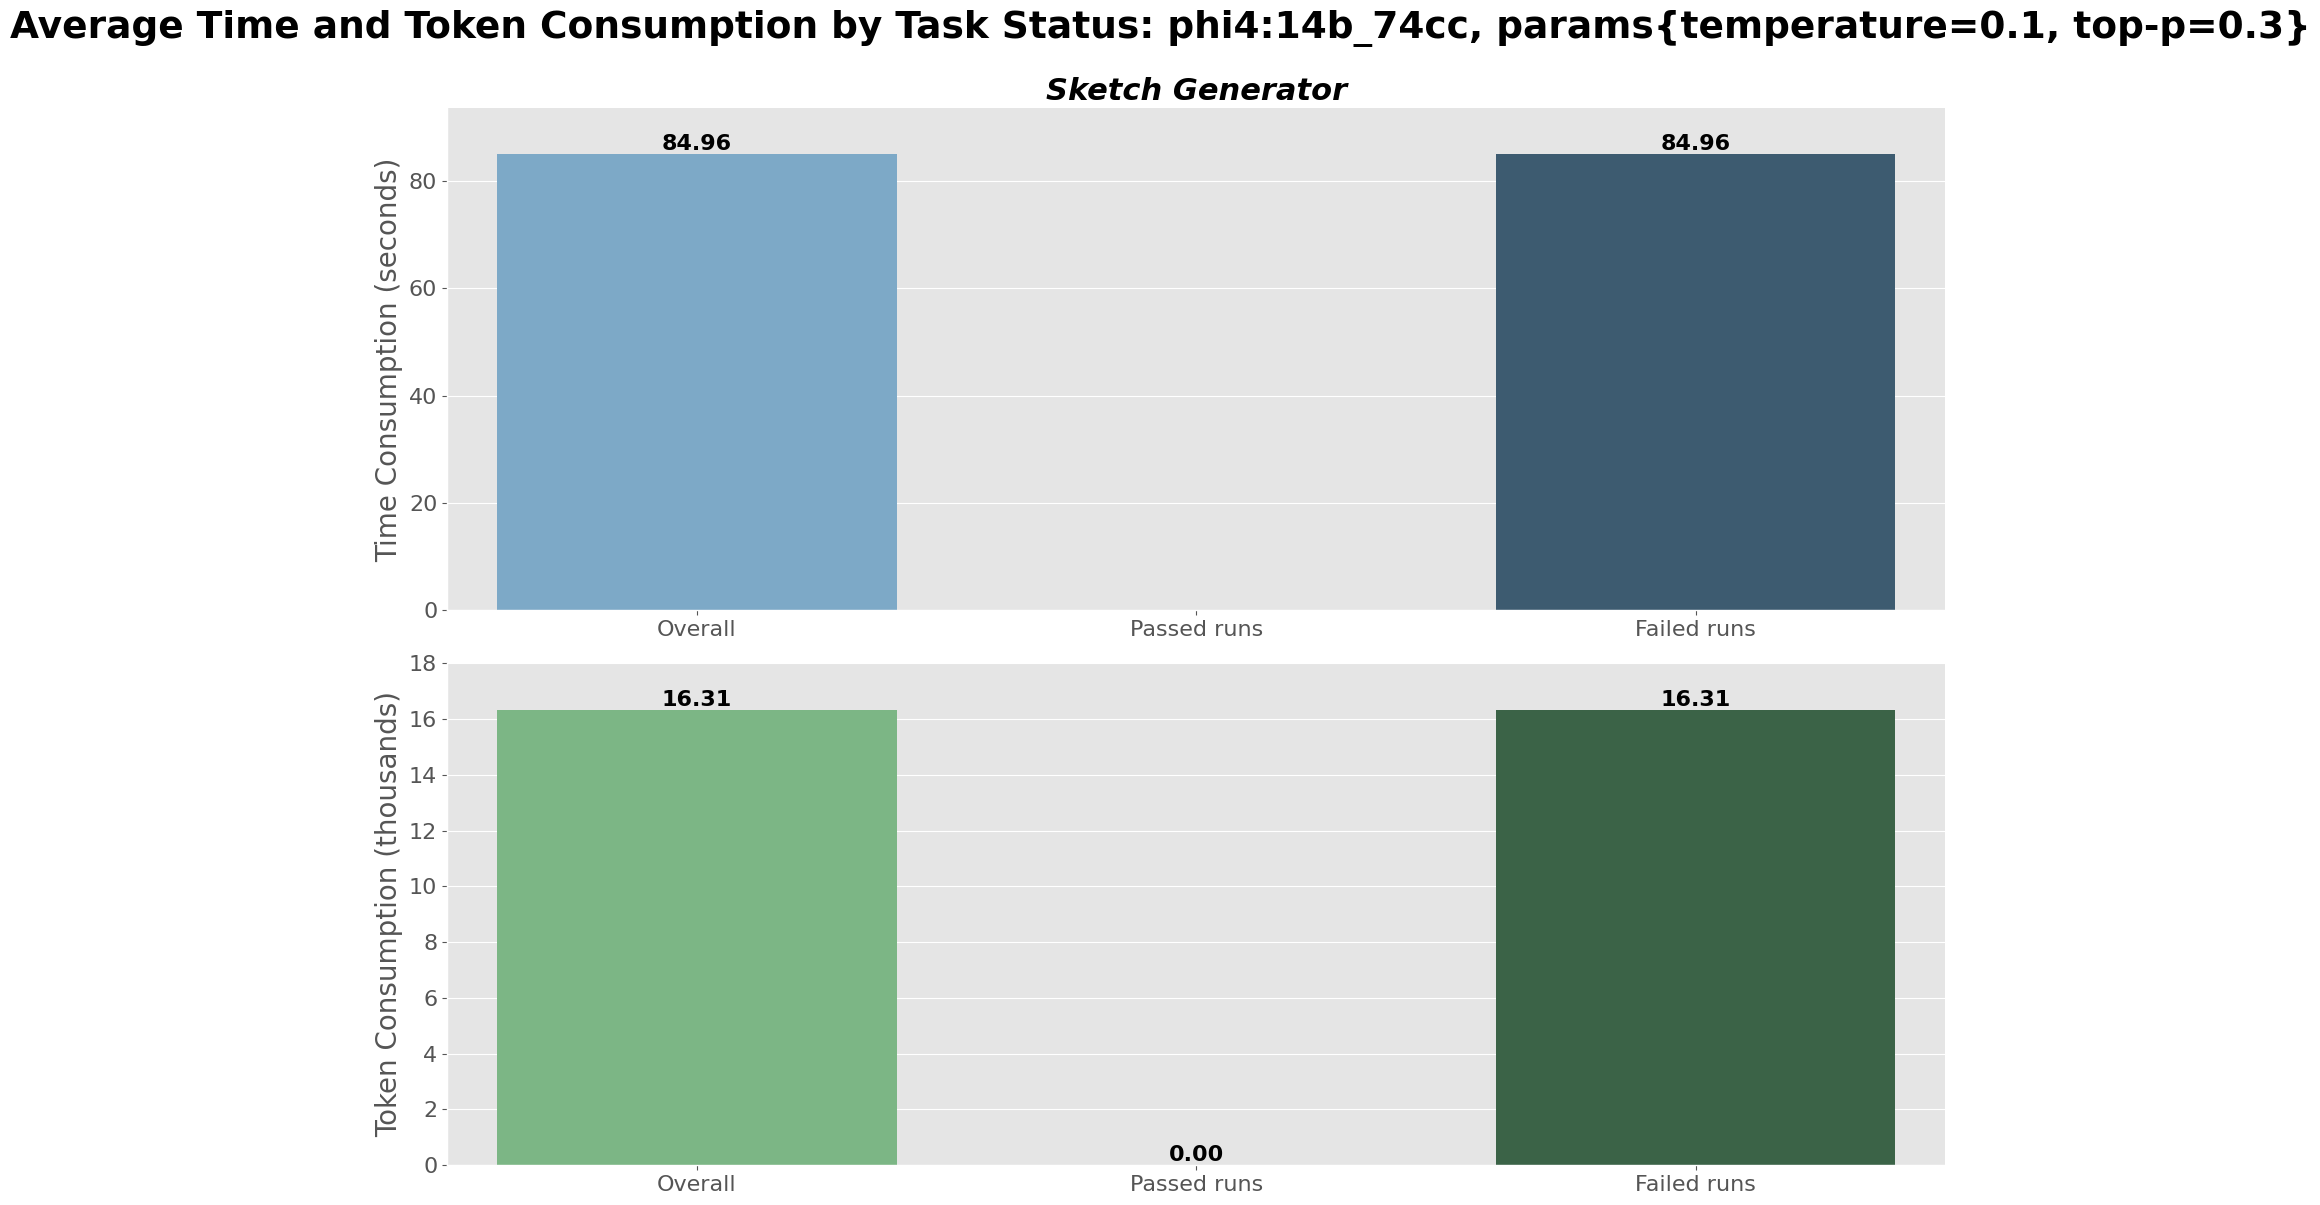

processing  clean_phi4_ebaa_mc_batch.csv
processing  clean_phi4_ebaa_dp_batch.csv
batch_info:  {'phi4_ebaa_mc': {'processor_type': 'model_converter', 'full_name': 'Model Converter', 'short_name': 'MC', 'model_name': 'phi4:latest'}, 'phi4_ebaa_dp': {'processor_type': 'data_processor', 'full_name': 'Data Processor', 'short_name': 'DP', 'model_name': 'phi4:latest'}}


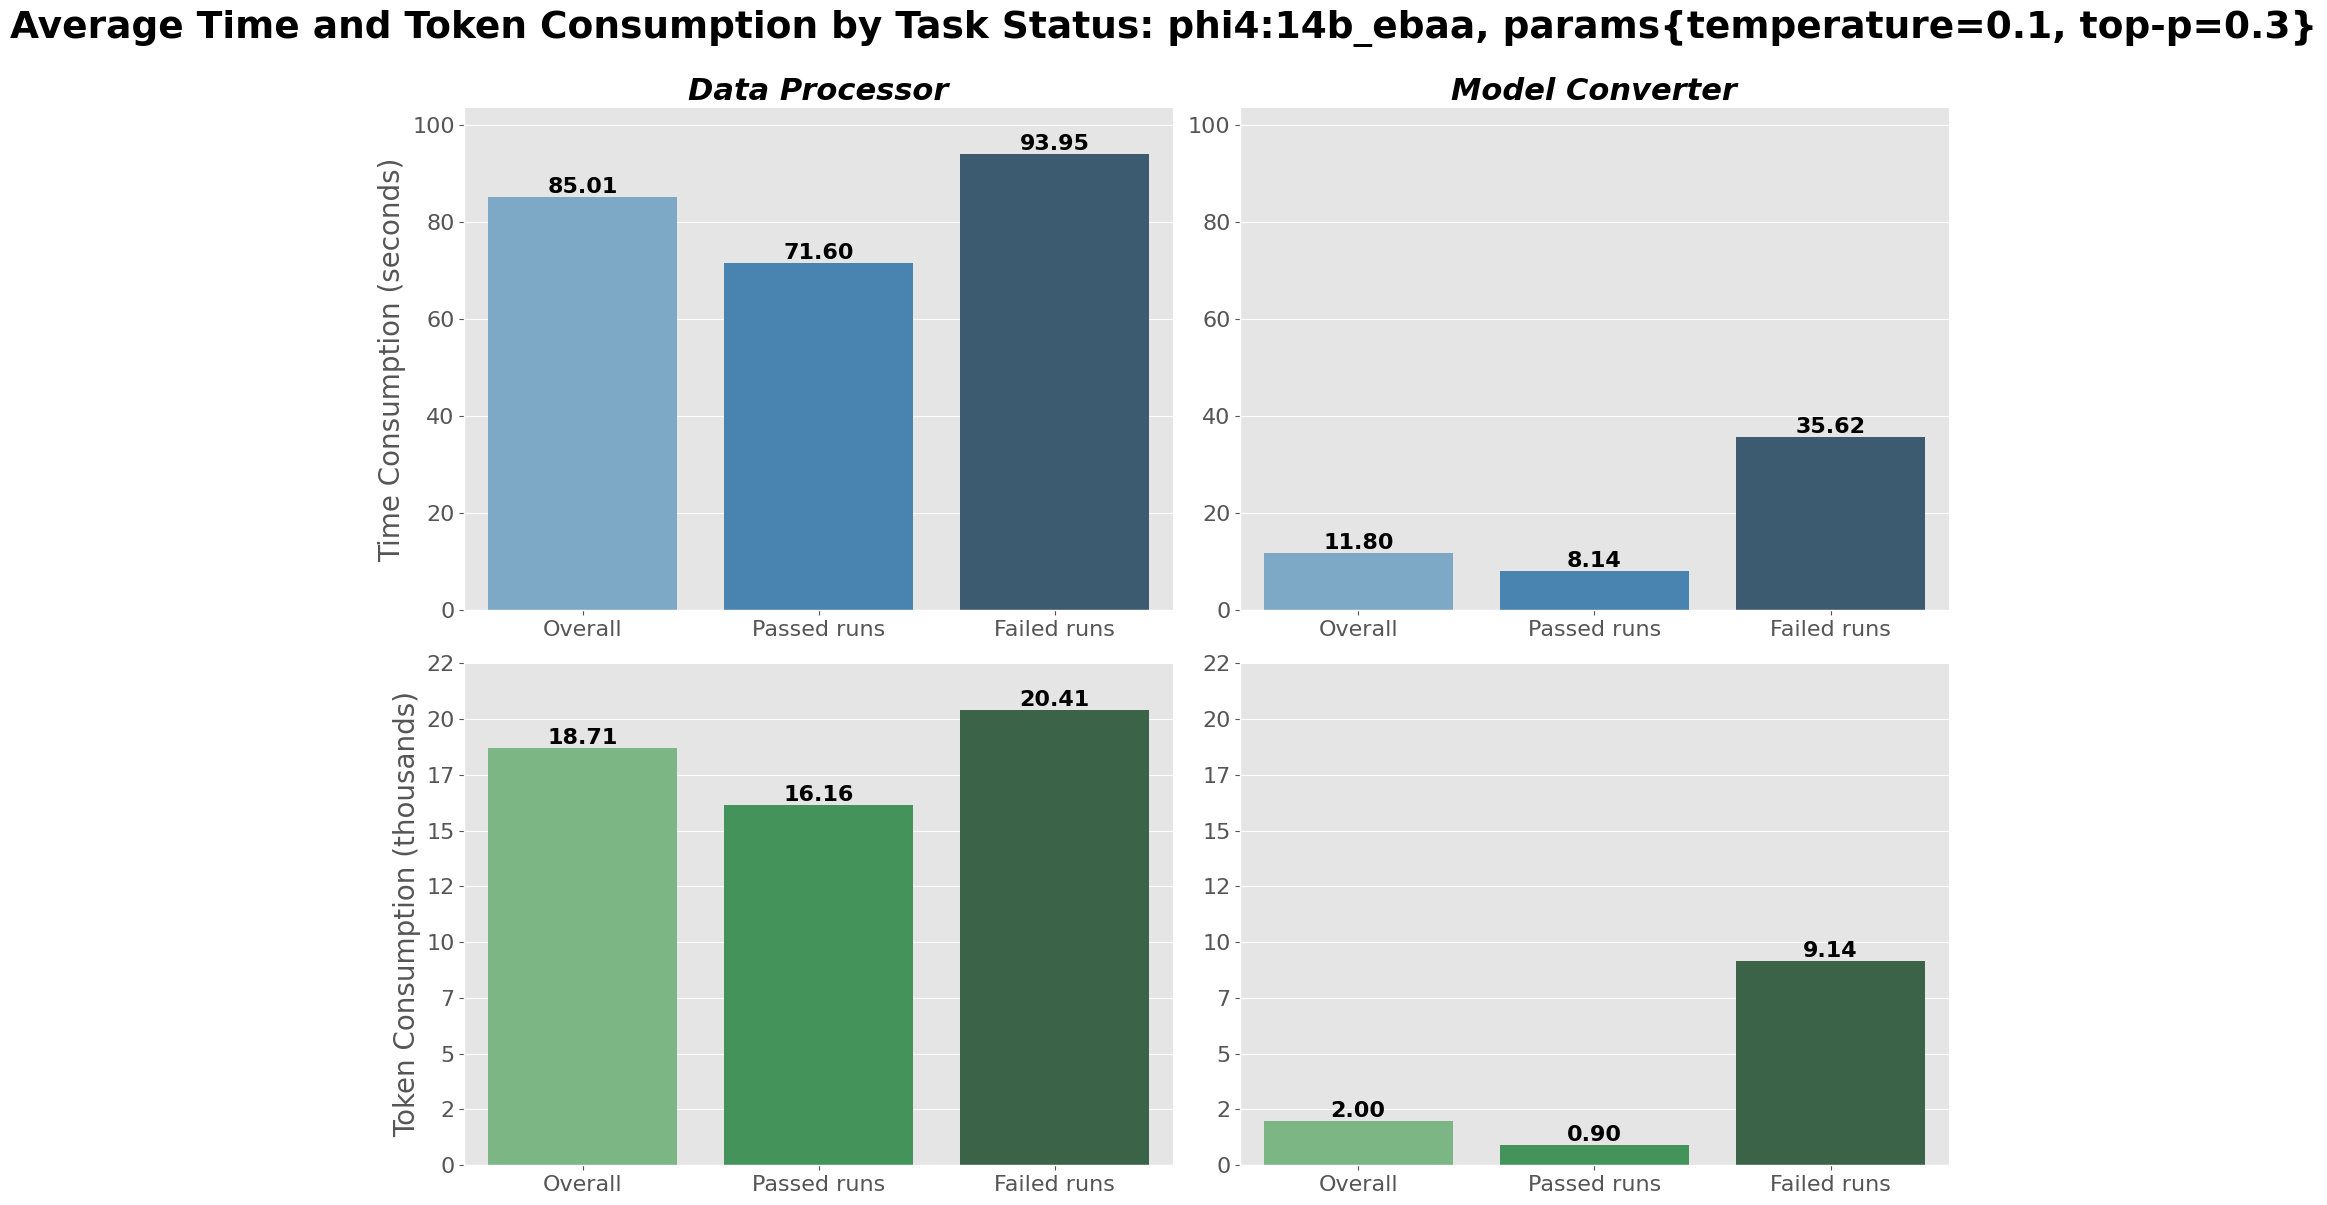

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define plot styling variables
SUPTITLE_SIZE = 27
TITLE_SIZE = 22
TICK_LABEL_SIZE = 16
ANNOTATION_SIZE = 16
AXIS_LABEL_SIZE = 20
FONT_WEIGHT = "bold"


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        return {k: int(v) if not pd.isna(v) else 0 for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["status"] == status]
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def prepare_data_for_plot(df, task_name):
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(df, "success")
    failed_stats = calculate_stats_by_status(df, "failure")

    data = []
    for metric in ["latency", "total_tokens"]:
        for status, stats in [
            ("Overall", overall_stats),
            ("Passed runs", passed_stats),
            ("Failed runs", failed_stats),
        ]:
            data.append(
                {
                    "Task": task_name,
                    "Metric": metric,
                    "Status": status,
                    "Average": stats[metric]["average"],
                    "Minimum": stats[metric]["minimum"],
                    "Maximum": stats[metric]["maximum"],
                }
            )
    return pd.DataFrame(data)


for dir in os.listdir(data_dir):
    # Load data using current workflow
    combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
    if combined_df.empty or len(batch_info) == 0:
        print("combined_df is empty, breaking")
        continue
    else:
        print("batch_info: ", batch_info)
    model_name = extract_model_name(batch_info)
    model_params = format_parameters_for_caption(combined_df).replace("_", r"-")
    batch_uid = list(batch_info)[0].split("_")[-2]
    # Prepare data for each task
    task_dfs = {}
    for processor_type in combined_df["processor_type"].unique():
        task_df = combined_df[combined_df["processor_type"] == processor_type]
        sample_batch_id = task_df["batch_id"].iloc[0]
        full_name = batch_info[sample_batch_id]["full_name"]
        task_dfs[full_name] = prepare_data_for_plot(task_df, full_name)

    # Combine all data
    df_all = pd.concat(task_dfs.values())

    # Determine global y-axis limits
    latency_max = df_all[df_all["Metric"] == "latency"]["Average"].max()
    tokens_max = df_all[df_all["Metric"] == "total_tokens"]["Average"].max()

    # Set the style
    plt.style.use("ggplot")
    sns.set_palette("muted")

    # Plotting
    tasks = df_all["Task"].unique()
    desired_order = STAGE_ORDER
    tasks = sorted(tasks, key=lambda x: desired_order.index(x))
    fig, axes = plt.subplots(nrows=2, ncols=len(tasks), figsize=(16, 12))
    # Ensure axes is 2D even with a single column
    if len(tasks) == 1:
        axes = axes.reshape(-1, 1)
    plt.subplots_adjust(top=0.85)

    for col, task in enumerate(tasks):
        task_data = df_all[df_all["Task"] == task]

        # Plot latency
        ax_latency = axes[0, col]
        latency_data = task_data[task_data["Metric"] == "latency"]
        sns.barplot(
            x="Status",
            y="Average",
            data=latency_data,
            ax=ax_latency,
            hue="Status",
            palette="Blues_d",
            legend=False,
        )
        ax_latency.set_ylabel(
            "Time Consumption (seconds)" if col == 0 else "", fontsize=AXIS_LABEL_SIZE
        )
        ax_latency.set_ylim(0, latency_max * 1.1)
        ax_latency.set_title(
            task, fontsize=TITLE_SIZE, fontweight=FONT_WEIGHT, style="italic"
        )

        # Annotate latency bars
        for i, bar in enumerate(ax_latency.patches):
            yval = bar.get_height()
            ax_latency.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.2f}",
                ha="center",
                va="bottom",
                fontweight=FONT_WEIGHT,
                fontsize=ANNOTATION_SIZE,
            )

        # Plot total tokens
        ax_tokens = axes[1, col]
        tokens_data = task_data[task_data["Metric"] == "total_tokens"]
        sns.barplot(
            x="Status",
            y="Average",
            data=tokens_data,
            ax=ax_tokens,
            hue="Status",
            palette="Greens_d",
            legend=False,
        )
        ax_tokens.set_ylabel(
            "Token Consumption (thousands)" if col == 0 else "",
            fontsize=AXIS_LABEL_SIZE,
        )
        ax_tokens.set_ylim(0, tokens_max * 1.1)

        # Set y-axis ticks manually
        y_ticks = ax_tokens.get_yticks()
        ax_tokens.set_yticks(y_ticks)
        ax_tokens.set_yticklabels([f"{int(tick/1000)}" for tick in y_ticks])

        # Annotate token bars
        for i, bar in enumerate(ax_tokens.patches):
            yval = bar.get_height()
            ax_tokens.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval/1000:.2f}",
                ha="center",
                va="bottom",
                fontweight=FONT_WEIGHT,
                fontsize=ANNOTATION_SIZE,
            )

        # Improve readability
        for ax in [ax_latency, ax_tokens]:
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.tick_params(axis="both", which="major", labelsize=TICK_LABEL_SIZE)
            ax.set_xlabel("")

    # Add overall title
    fig.suptitle(
        f"Average Time and Token Consumption by Task Status: {model_name}_{batch_uid}, params{{{model_params}}}",
        fontsize=SUPTITLE_SIZE,
        fontweight=FONT_WEIGHT,
        y=1,
    )
    plt.tight_layout()

    # Save and show plot
    plt.savefig(
        os.path.join(save_dir, f"bar_plot_{model_name}_{date_in_filename}_{batch_uid}.pdf"),
        format="pdf",
        dpi=400,
        bbox_inches="tight",
    )
    plt.show()

## 7. Scatter plot: time, token; success, error


processing  clean_phi4_74cc_sg_batch.csv
batch_info:  {'phi4_74cc_sg': {'processor_type': 'sketch_generator', 'full_name': 'Sketch Generator', 'short_name': 'SG', 'model_name': 'phi4:latest'}}


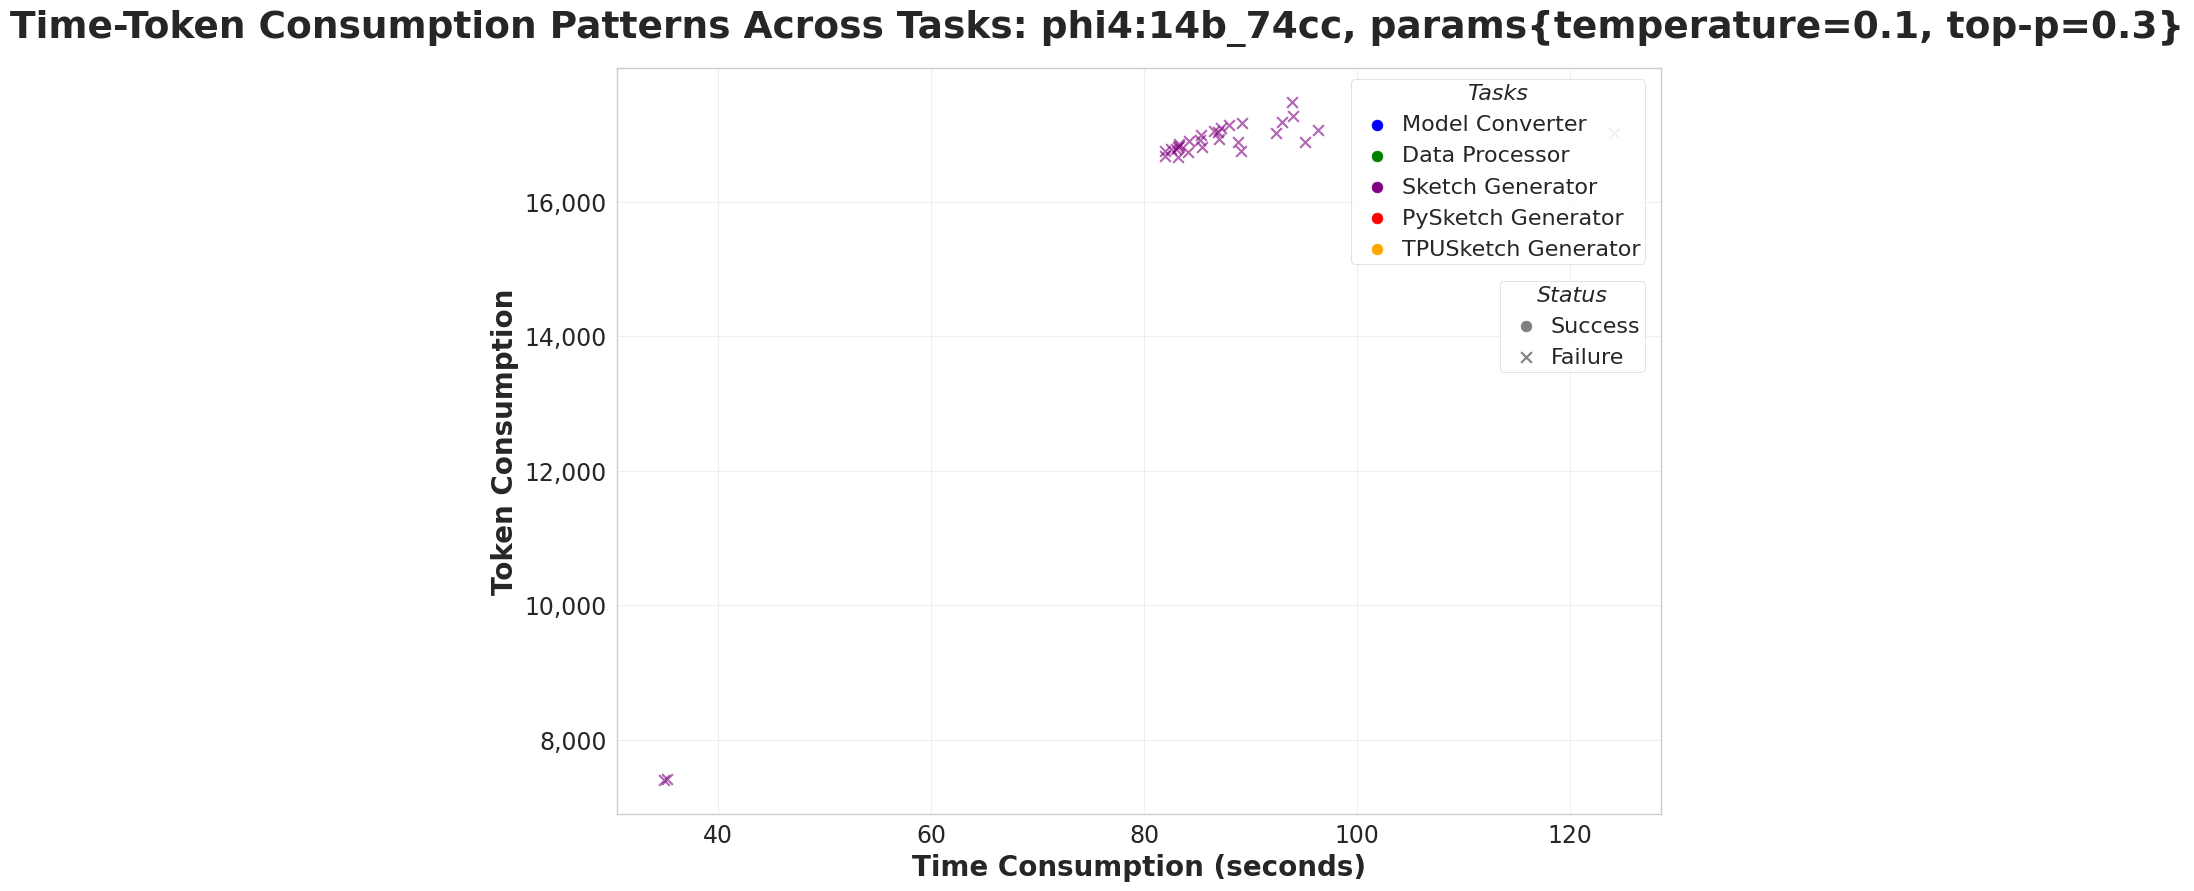

processing  clean_phi4_ebaa_mc_batch.csv
processing  clean_phi4_ebaa_dp_batch.csv
batch_info:  {'phi4_ebaa_mc': {'processor_type': 'model_converter', 'full_name': 'Model Converter', 'short_name': 'MC', 'model_name': 'phi4:latest'}, 'phi4_ebaa_dp': {'processor_type': 'data_processor', 'full_name': 'Data Processor', 'short_name': 'DP', 'model_name': 'phi4:latest'}}


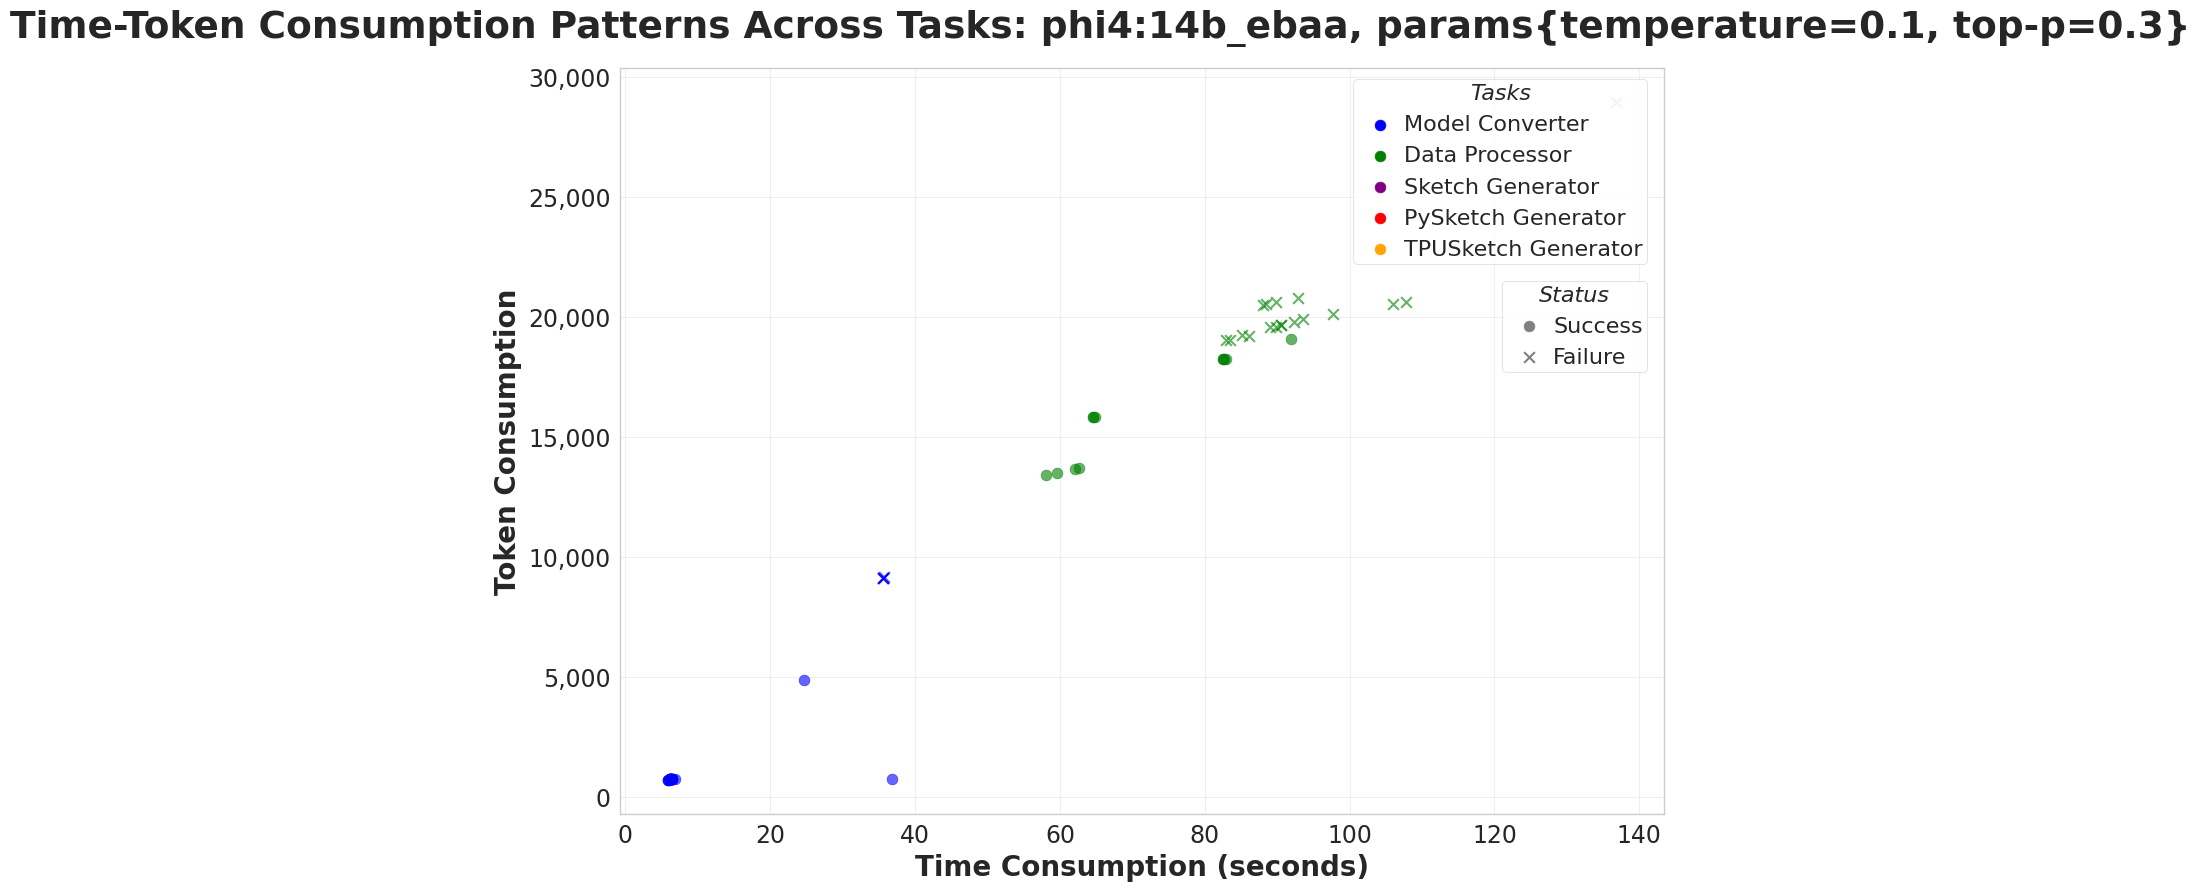

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

# Style parameters
title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"

title_fontsize = 27
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

for dir in os.listdir(data_dir):
    # Load data using current workflow
    combined_df, batch_info = process_batch_csvs(os.path.join(data_dir, dir))
    if combined_df.empty or len(batch_info) == 0:
        continue
    else:
        print("batch_info: ", batch_info)
    model_name = extract_model_name(batch_info)
    model_params = format_parameters_for_caption(combined_df).replace("_", r"-")
    batch_uid = list(batch_info)[0].split("_")[-2]
    # Set the style
    sns.set_style("whitegrid")

    # Create the figure
    plt.figure(figsize=(12, 9))

    # Define colors for each task (using full names from batch_info)
    task_colors = TASK_COLORS

    # Plot each task with different colors and markers
    for task_name, color in task_colors.items():
        # Filter data for current task
        task_data = combined_df[
            combined_df["batch_id"].apply(
                lambda x: batch_info[x]["full_name"] == task_name
            )
        ]

        # Plot successful runs
        success = task_data[task_data["status"] == "success"]
        plt.scatter(
            success["latency"],
            success["total_tokens"],
            color=color,
            alpha=0.6,
            label=task_name,
            marker="o",
            s=60,
        )

        # Plot failed runs
        failed = task_data[task_data["status"] == "failure"]
        plt.scatter(
            failed["latency"],
            failed["total_tokens"],
            color=color,
            alpha=0.6,
            marker="x",
            s=60,
        )

    # Labels and title
    plt.xlabel(
        "Time Consumption (seconds)",
        fontsize=label_fontsize,
        fontweight=label_fontweight,
    )
    plt.ylabel(
        "Token Consumption", fontsize=label_fontsize, fontweight=label_fontweight
    )
    plt.title(
        f"Time-Token Consumption Patterns Across Tasks: {model_name}_{batch_uid}, params{{{model_params}}}",
        fontsize=title_fontsize,
        loc="center",
        x=0.46,
        y=1.03,
        fontweight=title_fontweight,
    )
    plt.tick_params(axis="both", which="major", labelsize=17)

    # Format axis numbers
    plt.gca().yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda y, _: f"{int(y):,}")
    )
    plt.gca().xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f"{int(x):,}")
    )

    # Create legend handles
    task_handles = []
    task_labels = []
    status_handles = []
    status_labels = []

    # Collect task handles and labels
    for task, color in task_colors.items():
        task_handles.append(plt.scatter([], [], color=color, marker="o", s=60))
        task_labels.append(task)

    # Add status handles and labels
    status_handles.append(plt.scatter([], [], color="gray", marker="o", s=60))
    status_handles.append(plt.scatter([], [], color="gray", marker="x", s=60))
    status_labels.extend(["Success", "Failure"])

    legend_title_prop = {
        "weight": legend_fontweight,
        "size": legend_fontsize,
        "style": "italic",
    }

    # Create legends
    first_legend = plt.legend(
        task_handles,
        task_labels,
        loc="upper right",
        bbox_to_anchor=(0.995, 1.0),
        prop={"weight": legend_fontweight, "size": legend_fontsize},
        frameon=True,
        scatterpoints=1,
        markerscale=1,
        markerfirst=True,
        handletextpad=0.1,
        borderpad=0.2,
        edgecolor="lightgray",
        fancybox=True,
        shadow=False,
        framealpha=0.9,
        title="Tasks",
        title_fontproperties=legend_title_prop,
    )

    # Add the second legend for status markers
    plt.gca().add_artist(first_legend)
    plt.legend(
        status_handles,
        status_labels,
        loc="upper right",
        bbox_to_anchor=(0.995, 0.73),
        prop={"weight": legend_fontweight, "size": legend_fontsize},
        frameon=True,
        scatterpoints=1,
        markerscale=1,
        markerfirst=True,
        handletextpad=0.1,
        borderpad=0.2,
        edgecolor="lightgray",
        fancybox=True,
        shadow=False,
        framealpha=0.9,
        title="Status",
        title_fontproperties=legend_title_prop,
    )

    # Finishing touches
    plt.grid(True, linestyle="-", alpha=0.3)
    plt.tight_layout()

    # Save and show plot
    plt.savefig(
        os.path.join(save_dir, f"scatter_plot_{model_name}_{date_in_filename}_{batch_uid}.pdf"),
        format="pdf",
        dpi=400,
        bbox_inches="tight",
    )
    plt.show()

## 8. Compose LaTex report


In [11]:
import os
import re
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from datetime import datetime  # Add this line
from collections import deque


def extract_parameters(tex_file: Path) -> Optional[str]:
    """
    Extract parameters from the first .tex file in a batch.
    Looks for a string pattern ', Parameters: ... }'

    :param tex_file: Path to the .tex file
    :return: Parameter string if found, None otherwise
    """
    try:
        # Read first few lines of the file (parameters usually in header)
        with tex_file.open("r", encoding="utf-8") as f:
            content = "".join(deque(f, 10))

        # Find parameters using regex
        # print(content)
        match = re.search(r",\s*Parameters:\s*([^}]+)}", content)
        if match:
            return match.group(1).strip()
    except (IOError, StopIteration):
        pass
    return None


def extract_batch_uid(filename: str) -> Tuple[Optional[str], Optional[str]]:
    """
    Extracts a 4-digit batch UID and model name from the filename.
    Example: 'tab_token_details_phi4:14b_1234.tex' -> ('1234', 'phi4:14b')

    :param filename: The filename to extract information from
    :return: Tuple of (batch_uid, model_name)
    """
    filename, file_extension = os.path.splitext(filename)
    # print(f"Processing filename: {filename}, extension: {file_extension}")
    # filename=filename.removesuffix(".tex")
    uid = filename.split("_")[-1]
    # print(f"Spliting filename: {filename.split('_')}")
    
    model_name = filename.split("_")[-3]

    if str(model_name)==str(date):
        model_name = filename.split("_")[-4]
    # print(f"Extracted UID: {uid}, Model Name: {model_name} from filename: {filename}")
    return uid, model_name


def compose_latex_report_by_batch(
    save_dir: str,
    output_filename: str = "composed_report.tex",
) -> None:
    """
    Compose a LaTeX file that groups all .tex tables and plot files by their batch_uid.
    Files are grouped directly from save_dir (not from a tex subdirectory).
    Includes model parameters extracted from the first .tex file in each batch.

    :param save_dir: The directory containing the .tex and plot files
    :param output_filename: The name of the output .tex file to generate
    """
    save_dir = Path(save_dir)
    output_filename = f"{date_in_filename}.tex"
    output_path = save_dir / output_filename

    # Gather all .tex and plot files (recursively)
    files_by_batch: Dict[Tuple[str, str], List[Path]] = {}
    # print(f"This is the save_dir: {save_dir.rglob('*')}")
    for file in save_dir.rglob("*"):
        
        # print(f"Processing file: {file}")
        if not file.is_file():
            continue
        if file.resolve() == output_path.resolve():
            continue  # Skip the output file itself
        if file.suffix.lower() not in {".tex", ".pdf", ".png", ".jpg", ".jpeg"}:
            continue

        # print(f"Now extracting batch_uid and model_name from file: {file.name}")
        batch_uid, model_name = extract_batch_uid(file.name)
        if batch_uid and model_name:  # Only group files with both uid and model name
            key = (batch_uid, model_name)
            if key not in files_by_batch:
                files_by_batch[key] = []
            files_by_batch[key].append(file)

    # Sort by batch_uid and model_name
    sorted_keys = sorted(files_by_batch.keys())

    # check what processors are included in the batch, by getting all the filenames of json files under raw_export dir, and check, of "_dp_", "_mc_", "_sg_", "_psg_", "_tpusg_", which of them are in the filenames


    group_files = list(glob.glob(os.path.join(os.path.join(parent_dir, "raw_export"), "*.json")))

    included_processors = []
    for processor in ["_dp_", "_mc_", "_sg_", "_psg_", "_tpusg_"]:
        if any(processor in f for f in group_files):
            included_processors.append(processor.strip("_"))

    included_processors = ', '.join(included_processors).upper()


    with output_path.open("w", encoding="utf-8") as f:
        for batch_uid, model_name in sorted_keys:
            group_files = files_by_batch[(batch_uid, model_name)]

            # Separate .tex files and plot files
            tex_files = sorted([f for f in group_files if f.suffix.lower() == ".tex"])
            plot_files = sorted([f for f in group_files if f.suffix.lower() != ".tex"])

            # Extract parameters from the first .tex file
            parameters = None
            if tex_files:
                # parameters =
                parameters = str(extract_parameters(tex_files[0])).replace("_", r"-")

            # Write section header
            f.write("\\newpage\n")
            date_str = date
            section_title = f"{date_str}, Model: {model_name}"
            if parameters:
                section_title += f", Parameters: True"
            else:
                section_title += f", Parameters: False"


            f.write(f"\\subsection{{{section_title}}}\n\n")
            f.write(f"\\subsubsection*{{\\texttt{{{included_processors}; batch\_uid:{batch_uid}}}}}\n")
            f.write(f"\\addcontentsline{{toc}}{{subsubsection}}{{\\texttt{{{included_processors}; batch\_uid:{batch_uid}}}}}\n\n")
            # Add FloatBarrier before tables
            f.write("\\FloatBarrier\n")

            # Include all .tex files (tables) first
            for tex_file in tex_files:
                rel_path = tex_file.relative_to(save_dir)
                f.write(f"\\input{{{str(save_dir).split('tinyml_llm/')[1]}/{rel_path.as_posix()}}}\n")

            # Add newpage before figures
            if plot_files:  # Only add newpage if there are plots
                f.write("\\newpage\n")

            # Include all plot files
            for plot_file in plot_files:
                rel_path = plot_file.relative_to(save_dir)
                # Extract meaningful caption from filename
                caption_text = plot_file.stem.replace("_", " ").title()
                if plot_file.stem.startswith("bar"):
                    caption_text = "Average Time and Token Consumption by Task Status"
                    caption_text += f". Model: {model_name}, Date: {date}"
                    if parameters:
                        caption_text += f", Parameters: {parameters}"
                    caption_text += " \\\\ \\textit{The average time (top) and token consumption (bottom) are compared across three stages, broken down by overall performance (considering all runs), performance of only successful runs, and of only the failed runs.}"
                else:
                    caption_text = f"Distribution of time and token consumption in three tasks. Model: {model_name}, Date: {date}"
                    if parameters:
                        caption_text += f", Parameters: {parameters}"

                f.write(
                    "\\begin{figure}[!h]\n"
                    "    \\centering\n"
                    f"    \\includegraphics[width=0.75\\linewidth]{{{str(save_dir).split('tinyml_llm/')[1]}/{rel_path.as_posix()}}}\n"
                    f"    \\caption{{{caption_text}}}\n"
                    f"    \\label{{fig:{plot_file.stem}}}\n"
                    "\\end{figure}\n\n"
                )

    print(f"LaTeX report composed at: {output_path}")

    # Insert the latext report to inserted_data_analysis.tex
    
    main_tex_path=os.getcwd().split('data_analysis')[0]+"inserted_data_analysis.tex"
    # check if the f"\\input{{{str(output_path).split('tinyml_llm/')[1]}}}" is already in the main_tex
    insertion_checker=f"\\input{{{str(output_path).split('tinyml_llm/')[1]}}}"

    if insertion_checker not in open(main_tex_path).read():
        with open(main_tex_path, "a", encoding="utf-8") as f:
            f.write(f"\\input{{{str(output_path).split('tinyml_llm/')[1]}}}\n\\clearpage\n")

In [12]:
compose_latex_report_by_batch(save_dir)

LaTeX report composed at: /home/han/Projects/reference-benchmark-tinyml_llm/data_analysis/2025/11.05/tex/11.05.tex
